<a href="https://colab.research.google.com/github/imazzala/Introduccion-Machine-Learning-Pytorch/blob/main/ModeloReconocimientoImagenes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento de Imágenes a través de modelos pre entrenados

Pytorch tiene dentro de su librería modelos ya entrenados que podemos utilizar. El módulo torchvision tiene un módulo de ut¡lidades para obtener la red neuronal (utils) y se usará el módulo modelos.

El módulo datasets y transforms se utilizarán para desarrollar nuestros propios modelos en la segunda parte de la clase. 

La librería PIL se utiliza para manipular imágenes y la librería urrlib.request se utilizará para traer imágenes desde internet. 

In [2]:
import torch

from torchvision import utils
from torchvision import models
from torchvision import datasets
from torchvision import transforms

from PIL import Image
import urllib.request as request
from matplotlib import pyplot as plt

# Modelo pre entrenado

____

El modelo inception es un modelo de computer visión. La red neuronal puede estar pre-entrenada como en este caso, o la podemos entrenar nosotros mismos. 

In [3]:
inception = models.inception_v3(pretrained = True)

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth


Con urlretrieve, traemos el archivo de internet y lo guardamos con un nombre, en este caso 'test.jpg'. Con el método Image.open abrimos el path de la imagen.

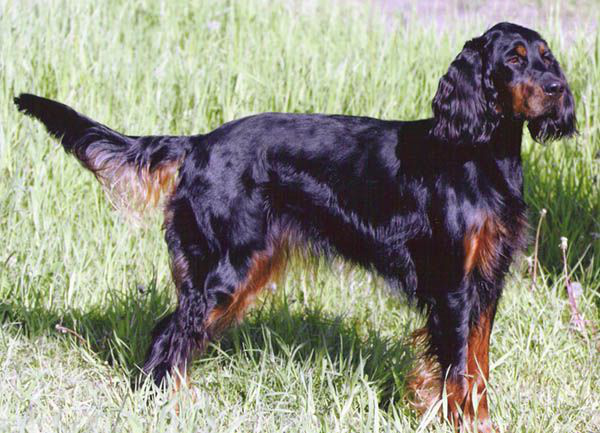

In [4]:
url = 'https://i.pinimg.com/originals/fd/43/80/fd43802c7e43815f8edb0d46fc8ee746.jpg'
image = request.urlretrieve(url, 'test.jpg')
img = Image.open(image[0])
img

Ejecutamos una serie de procesamientos a la imagen para que tenga el mismo formato que el utilizado para el entrenamiento. En primer lugar se utliza el método Compose, el cual permite ejecutar más de una transformación. Las imágenes utilizadas para entrenar deben ser más chicas, por otro lado, se centra al centro con el método CeterCrop. El método ToTensor nos permite transformar la imágenes en datos numéricos y finalmente se ejectuta una normalización, la cual se explicita en la documentación de Pytorch. 

In [5]:
preprocess = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(150),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])

Debemos agregar una dimensión adicional que nos solicita el modelo. Para poder graficar la imagen es necesario realizar una permutación de los datos ya que al convertirse en un Tensor, se transponen los datos. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


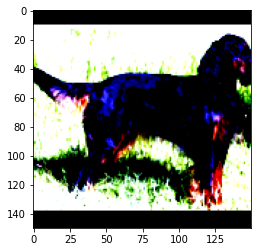

In [8]:
img_t = preprocess(img)
batch = torch.unsqueeze(img_t, 0)
plt.imshow(img_t.permute(1,2,0))


In [9]:
inception.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

Ejecutamos el modelo sobre nuestra imagen, esto nos devuelve un tensor.

In [10]:
out = inception(batch)


Cargamos todas las etiquetas que usadas para entrenar el modelo inception

In [11]:
request.urlretrieve('https://gist.githubusercontent.com/ykro/acb00a36f737c12013f6e0f8a0d2cb61/raw/a2bb113b83e274048992f6550050a437fa4db76d/imagenet_classes.txt', 'labels.txt')
with open('labels.txt') as f:
  labels = [line.strip() for line in f.readlines()]

Con la función max le da sentido al output, podemos determinar la probabilidad asociada a la predicción calculada por el modelo. 

In [17]:
_ , index = torch.max(out, 1)

In [18]:
porcentage = torch.nn.functional.softmax(out, dim = 1)[0] * 100
labels[index[0]], porcentage[index[0]].item()

('Gordon setter', 100.0)

# Trabajando con un DataSet

Se entrenará un modelo a partir de un DataSet. Descargamos el DataSet CIFAR 10, entre los parámetros que le brindamos tenemos el path donde se va a descargar, le indicamos si los datos son los de entrenamiento o los de validación a partir del parámetro train y si deseamos descargar el DataSet a nuestro disco local.

In [5]:
data_path = 'data/'
dataset = datasets.CIFAR10(data_path, train = True, download = True)
validation_set = datasets.CIFAR10(data_path, train = False, download = True)

Extracting data/cifar-10-python.tar.gz to data/
Files already downloaded and verified


Buscamos las clases de los elementos que componen el DataSet. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [6]:
classes = ['plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

In [7]:
len(dataset)

50000

In [11]:
img, label = dataset[50]
img, label, classes[label]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7853497908>, 9, 'truck')

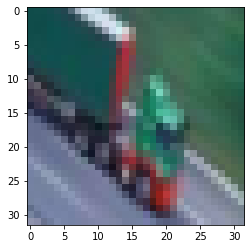

In [12]:
plt.imshow(img)

Convertirmos la imagen a un tensor a través del método transfors.ToTensor. 

In [14]:
tensor_transform = transforms.ToTensor()
img_tensor = tensor_transform(img)
img, img_tensor, img_tensor.shape

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7F7853497908>,
 tensor([[[0.0627, 0.0667, 0.0667,  ..., 0.2431, 0.2157, 0.2000],
          [0.0627, 0.0627, 0.0588,  ..., 0.2431, 0.2275, 0.2039],
          [0.0627, 0.0588, 0.0588,  ..., 0.2235, 0.2314, 0.2196],
          ...,
          [0.3765, 0.4471, 0.4667,  ..., 0.5020, 0.4706, 0.4588],
          [0.4627, 0.3922, 0.4471,  ..., 0.5451, 0.5137, 0.4745],
          [0.5647, 0.5333, 0.4118,  ..., 0.5686, 0.5373, 0.5137]],
 
         [[0.2980, 0.3020, 0.3020,  ..., 0.4157, 0.3882, 0.3686],
          [0.2980, 0.2980, 0.2941,  ..., 0.4275, 0.4118, 0.3922],
          [0.2980, 0.2941, 0.2941,  ..., 0.4314, 0.4353, 0.4275],
          ...,
          [0.4314, 0.4980, 0.5176,  ..., 0.5294, 0.5098, 0.5137],
          [0.5176, 0.4431, 0.4941,  ..., 0.5725, 0.5490, 0.5255],
          [0.5804, 0.5490, 0.4471,  ..., 0.5922, 0.5647, 0.5529]],
 
         [[0.2902, 0.2941, 0.2941,  ..., 0.3412, 0.3137, 0.2941],
          [0.2902, 0.2902, 0.2902,  ..., 0

Aplicamos una transformacióna a todo el DataSet, descargandolo nuevamente y pasándole el parámetro Transform = transforms.ToTensor(). De esta forma todo el Data Set ahora está representado por tensores. 

In [17]:
dataset = datasets.CIFAR10(data_path, train = True, download = True, transform = transforms.ToTensor())

Files already downloaded and verified


Analizamos ahora que los datos ubicados anteriormente ahora se corresponden con un Tensores. 

In [20]:
img, label = dataset[50]
img

tensor([[[0.0627, 0.0667, 0.0667,  ..., 0.2431, 0.2157, 0.2000],
         [0.0627, 0.0627, 0.0588,  ..., 0.2431, 0.2275, 0.2039],
         [0.0627, 0.0588, 0.0588,  ..., 0.2235, 0.2314, 0.2196],
         ...,
         [0.3765, 0.4471, 0.4667,  ..., 0.5020, 0.4706, 0.4588],
         [0.4627, 0.3922, 0.4471,  ..., 0.5451, 0.5137, 0.4745],
         [0.5647, 0.5333, 0.4118,  ..., 0.5686, 0.5373, 0.5137]],

        [[0.2980, 0.3020, 0.3020,  ..., 0.4157, 0.3882, 0.3686],
         [0.2980, 0.2980, 0.2941,  ..., 0.4275, 0.4118, 0.3922],
         [0.2980, 0.2941, 0.2941,  ..., 0.4314, 0.4353, 0.4275],
         ...,
         [0.4314, 0.4980, 0.5176,  ..., 0.5294, 0.5098, 0.5137],
         [0.5176, 0.4431, 0.4941,  ..., 0.5725, 0.5490, 0.5255],
         [0.5804, 0.5490, 0.4471,  ..., 0.5922, 0.5647, 0.5529]],

        [[0.2902, 0.2941, 0.2941,  ..., 0.3412, 0.3137, 0.2941],
         [0.2902, 0.2902, 0.2902,  ..., 0.3294, 0.3137, 0.2941],
         [0.2902, 0.2863, 0.2863,  ..., 0.3098, 0.3137, 0.

In [21]:
img.min(), img.max()

(tensor(0.0314), tensor(0.9529))

Vemos que la imagen es la misma, solo que la forma en la cual se representa ahora cambia, es diferente. 

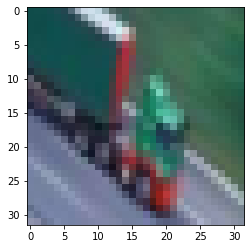

In [23]:
plt.imshow(img.permute(1,2,0))

Esta reprensentación la queremos en todas las imágenes, entonces armamos un stack con todos los tensores

In [24]:
imgs = torch.stack([img_tensor for img_tensor, _ in dataset], dim = 3)

In [25]:
imgs.shape

torch.Size([3, 32, 32, 50000])

Calculamos la media y el desvío estandar de todas las imágenes. 

In [26]:
imgs.view(3, -1).mean(dim = 1)

tensor([0.4914, 0.4822, 0.4465])

In [27]:
imgs.view(3, -1).std(dim = 1)

tensor([0.2470, 0.2435, 0.2616])

Normalizamos los datos a través de la media y la desviación estandard calculadas

In [29]:
transform = transforms.Compose([
            transforms.ToTensor(), 
            transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
])

In [30]:
dataset = datasets.CIFAR10(data_path, train = True, download = True, transform = transform)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'bird'

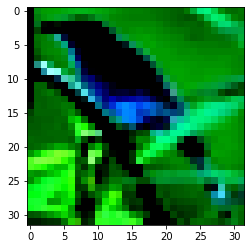

In [38]:
img_transformed, label = dataset[800]
plt.imshow(img_transformed.permute(1,2,0))
classes[label]